In [1]:
import sqlalchemy as sa
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display
import datetime

## Dependencies to manipulate Control Variables
import os
from dotenv import dotenv_values

ENV_FILE='.env' # <- CHANGE THIS TO PLOT YOUR CONFIGURATION

dotenv_path = os.path.join('.env')
config = dotenv_values(dotenv_path)

# Control Values
DB_HOST=config['DB_HOST']
DB_PORT=config['DB_PORT']
DB_NAME=config['DB_NAME']
DB_USER=config['DB_USER']
DB_PASSWD=config['DB_PASSWD']
FIGS_FOLDER=config['FIGS_FOLDER']
## SQL queries related stuff
START_DATE=datetime.datetime.strptime(config['START_DATE'], '%Y-%m-%d')
FINISH_DATE=datetime.datetime.strptime(config['FINISH_DATE'], '%Y-%m-%d')
# Configure the main plotting configuration
## Plot related
FIG_SIZE=(10,6)
sns.set_context("talk", font_scale=1)

## DB Credentials
print(
    f'connecting to database "{DB_NAME}" at "{DB_HOST}"\n',
    f'keeping plots at "{FIGS_FOLDER}"'
)

engine = sa.create_engine(
    f'postgresql://{DB_USER}:{DB_PASSWD}@{DB_HOST}:{DB_PORT}/{DB_NAME}')
con = engine.connect()

connecting to database "hoarder_prod" at "ec2-3-66-188-202.eu-central-1.compute.amazonaws.com"
 keeping plots at "./pics/"


,prov_op,ping_round,fetch_time_since_publication_m,success_att,fail_att
0,std-dht-provide,0,3.966667e-09,17,3
1,std-dht-provide,0,3.900000e-09,13,7
2,std-dht-provide,0,3.650000e-09,14,6
3,std-dht-provide,0,3.700000e-09,17,3
4,std-dht-provide,0,4.116667e-09,17,3
...,...,...,...,...,...
3908998,std-dht-provide,96,2.880419e+03,19,1
3908999,std-dht-provide,96,2.880322e+03,17,3
3909000,std-dht-provide,96,2.880178e+03,18,2
3909001,std-dht-provide,96,2.882254e+03,18,2


,prov_op,ping_round,fetch_time_since_publication_m,ping_delay
1,std-dht-provide,1,30.451963,30.451963
2,std-dht-provide,2,60.454274,30.227137
3,std-dht-provide,3,90.458640,30.152880
4,std-dht-provide,4,120.459532,30.114883
5,std-dht-provide,5,150.462997,30.092599
...,...,...,...,...
92,std-dht-provide,92,2760.475873,30.005173
93,std-dht-provide,93,2790.473071,30.005087
94,std-dht-provide,94,2820.475208,30.005055
95,std-dht-provide,95,2850.471896,30.004967


/tmp/ipykernel_6953/476131684.py:42: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(FIGS_FOLDER+'scatter_online_pr_holders.png')
/tmp/ipykernel_6953/476131684.py:46: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(FIGS_FOLDER+'scatter_online_pr_holders.png')
/tmp/ipykernel_6953/476131684.py:51: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(FIGS_FOLDER+'stripp_online_pr_holders.png')
/tmp/ipykernel_6953/476131684.py:55: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(FIGS_FOLDER+'stripp_online_pr_holders.png')


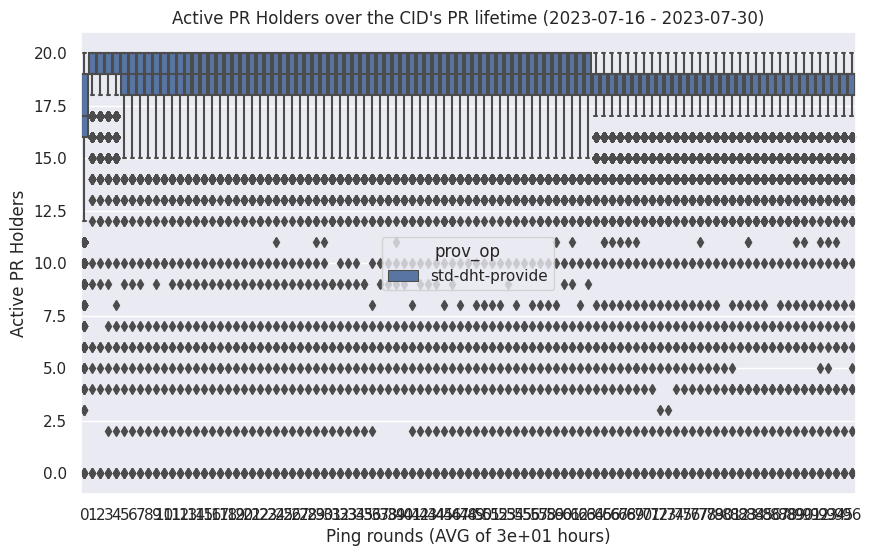

/home/cortze/devel/cortze/ipfs-cid-hoarder/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


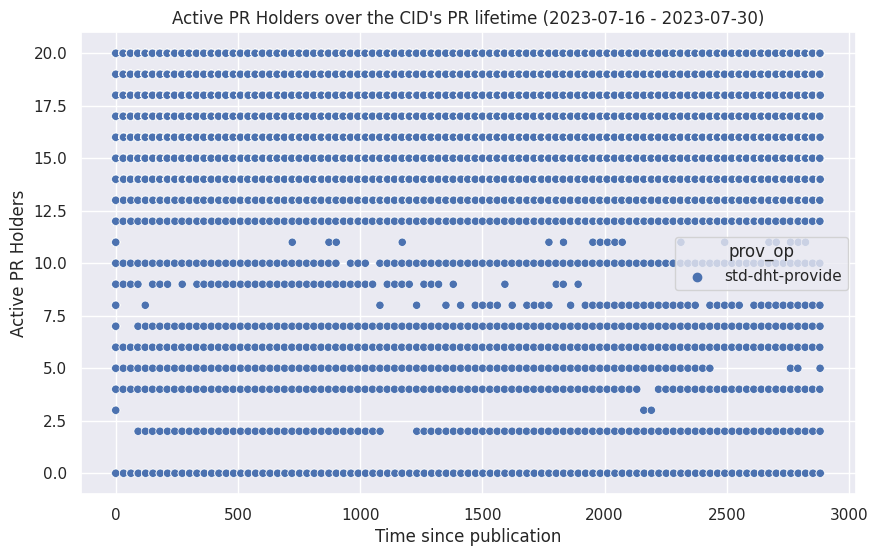

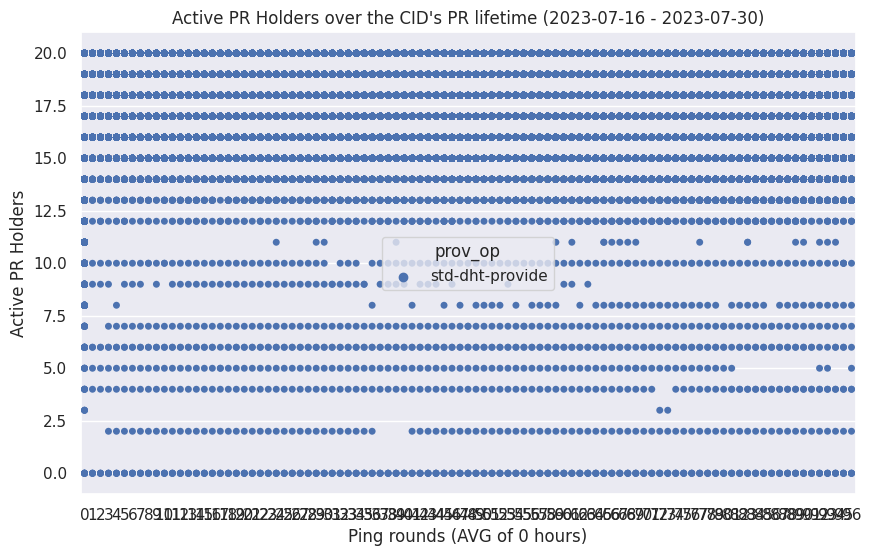

In [2]:
# Analyze each of the Fetch per CID
## Ping Results
## SQL Query
query = f"""
    SELECT
        prov_op,
        ping_round,
        fetch_time_since_publication_m,
        success_att,
        fail_att
    FROM fetch_results
    JOIN cid_info ON fetch_results.cid_hash = cid_info.cid_hash
    WHERE
        pub_time>='{START_DATE}' and pub_time<='{FINISH_DATE}'
    ORDER BY prov_op ASC, ping_round ASC;
"""

df = pd.read_sql_query(sa.text(query), con)
#df['fetch_time_since_publication_m'] = df['fetch_time_since_publication_m'] / (1000_000_000*60*60) # nanosecs -> hours
display(df)

## Get the AVG ping time per round
avg_ping_times = df.groupby(['prov_op', 'ping_round'])['fetch_time_since_publication_m'].mean()
avg_ping_times = avg_ping_times.reset_index()
avg_ping_times['ping_delay'] = avg_ping_times['fetch_time_since_publication_m'] / avg_ping_times['ping_round']
avg_ping_times = avg_ping_times[avg_ping_times['ping_round'] > 0]
display(avg_ping_times)


## Display the quartiles of the successfull peers distribution
sns.set()
plt.figure(figsize=FIG_SIZE)
g = sns.boxplot(x='ping_round', y='success_att', hue='prov_op', data=df)
g.set(xlabel='Ping rounds (AVG of {0:.1g} hours)'.format(avg_ping_times["ping_delay"].mean()),
      ylabel='Active PR Holders',
      title=f"Active PR Holders over the CID's PR lifetime ({START_DATE.date()} - {FINISH_DATE.date()})")
plt.savefig(FIGS_FOLDER+'quart_online_pr_holders.png')

sns.set()
plt.figure(figsize=FIG_SIZE)
g = sns.scatterplot(x='fetch_time_since_publication_m', y='success_att', hue='prov_op', data=df)
plt.savefig(FIGS_FOLDER+'scatter_online_pr_holders.png')
g.set(xlabel=f'Time since publication',
      ylabel='Active PR Holders',
      title=f"Active PR Holders over the CID's PR lifetime ({START_DATE.date()} - {FINISH_DATE.date()})")
plt.savefig(FIGS_FOLDER+'scatter_online_pr_holders.png')

sns.set()
plt.figure(figsize=FIG_SIZE)
g = sns.stripplot(x='ping_round', y='success_att', hue='prov_op', data=df, dodge=True, jitter=False)
plt.savefig(FIGS_FOLDER+'stripp_online_pr_holders.png')
g.set(xlabel=f'Ping rounds (AVG of {0:.1g} hours)'.format(avg_ping_times["ping_delay"].mean()),
      ylabel='Active PR Holders',
      title=f"Active PR Holders over the CID's PR lifetime ({START_DATE.date()} - {FINISH_DATE.date()})")
plt.savefig(FIGS_FOLDER+'stripp_online_pr_holders.png')

In [ ]:
## Individual Pings
## SQL Query
query = f"""
    SELECT
        *
    FROM ping_results
    JOIN cid_info ON ping_results.cid_hash = cid_info.cid_hash
    WHERE
        pub_time>='{START_DATE}' and pub_time<='{FINISH_DATE}';
"""

df = pd.read_sql_query(sa.text(query), con)
#df['fetch_time_since_publication_m'] = df['fetch_time_since_publication_m'] / (1000_000_000*60*60) # nanosecs -> hours
display(df)


In [ ]:
## Get the active peers distribution per ping_round

sql_query = """
	SELECT
		ping_round,
		conn_error,
		count(conn_error) as error_count
	FROM ping_results
	GROUP BY ping_round, conn_error
	ORDER BY ping_round, conn_error;
"""

error_dists = pd.read_sql_query(sa.text(sql_query), con)

# plot
pv_table = error_dists.pivot(index=["ping_round"], columns="conn_error", values="error_count")
pv_table = pv_table.fillna(0)
aux = pd.DataFrame(pv_table.to_records())

print(aux)

aux = aux.drop("ping_round", axis=1)
## Make a boxplot with the distribution
aux.plot()
plt.xlabel("Time Since Publication (Hours)")
plt.ylabel("Error Count")
plt.legend(loc="center left", bbox_to_anchor=(1, 0, 0.5, 1), prop={'size': 16})
plt.show()

In [3]:
engine.dispose()
